In [7]:
import os
# os.chdir(os.path.dirname(os.path.abspath(__file__)))
from glob import glob
import re, numpy as np

toplot = sorted(glob('./measures*averaged*.csv'))

toplot = {int(re.search(r'_(\d\d+)spl',x).group(1)):x for x in toplot}
print(toplot)

{1024: '.\\measures_1024spl_averaged.csv', 64: '.\\measures_64spl_averaged.csv'}


In [8]:
import pandas as pd
# Load data
dataDict = {k:pd.read_csv(v) for k,v in toplot.items()}
# Convert to a single dataframe, where the key is checked against the 'spl' column of the item (pd dataframe)
for key,item in dataDict.items():
    for spl in item['spl']:
        # print(spl, key)
        assert spl == key, 'spl column does not match key ({} != {})'.format(spl, key)
# Now that we are sure, concat all the dataframes into a single one
data = pd.concat(dataDict.values())

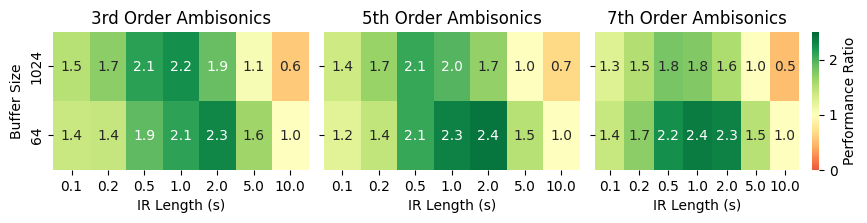

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

numeral_to_ordinal = lambda n: f'{n}{"tsnrhtdd"[((n//10%10!=1)*(n%10<4)*n%10)::4]}'

# Create performance ratio heatmap
def create_performance_heatmap(data, title=False):
    # newPlugin_data, oldPlugin_data, ambisonics_orders, buffer_sizes, ir_lengths, 
    channel_numbers = data['channels'].unique()
    ambisonics_orders = np.sqrt(channel_numbers)-1
    buffer_sizes = data['spl'].unique()
    ir_lengths = data['irlen_s'].unique()

    # print(channel_numbers, ambisonics_orders, buffer_sizes, ir_lengths)
    # oldPlugin_data should be in the shape of (channel_numbers, buffer_sizes, ir_lengths) and taken from data
    def get_plottable(data, plugin, channel_numbers, buffer_sizes, ir_lengths):
        plottable = np.zeros((len(channel_numbers), len(buffer_sizes), len(ir_lengths)))
        for idx, channels in enumerate(channel_numbers):
            for idx2, buffer_size in enumerate(buffer_sizes):
                for idx3, ir_length in enumerate(ir_lengths):
                    plottable[idx, idx2, idx3] = data[(data['channels'] == channels) & (data['spl'] == buffer_size) & (data['irlen_s'] == ir_length) & (data['plugin'] == plugin)]['X_mean'].values[0]
        return plottable
    
    oldPlugin_data = get_plottable(data, 'old', channel_numbers, buffer_sizes, ir_lengths)
    newPlugin_data = get_plottable(data, 'new', channel_numbers, buffer_sizes, ir_lengths)


    # Calculate performance ratio
    performance_ratio = newPlugin_data/oldPlugin_data
    
    # Create figure with subplots for different ambisonic orders
    fig, axes = plt.subplots(1, len(ambisonics_orders), figsize=(9, 1+len(buffer_sizes)/3*2), sharey=True)
    if title:
        fig.suptitle('Speedup ratio of New MCFX-6DoFConv Plugin over SPARTA 6DoFConv', fontsize=16)
    
    # Plot heatmap for each ambisonics order
    for idx, order in enumerate(ambisonics_orders):
        # Extract data for specific ambisonics order
        data = performance_ratio[idx, :, :]
        
        round_to_next_half = lambda x: np.ceil(x*2)/2

        # # Create heatmap
        # sns.heatmap(data, 
        #             ax=axes[idx], 
        #             cmap='RdYlGn',  # Red-Yellow-Green reversed (red = worse, green = better)
        #             cbar=idx == len(ambisonics_orders)-1,  # Only add colorbar to last subplot
        #             annot=True, 
        #             fmt='.1f',
        #             vmin=0, 
        #             vmax=round_to_next_half(max(performance_ratio.max(), 1.5)),
        #             center=1,
        #             cbar_kws={'label': 'Performance Ratio'} if idx == len(ambisonics_orders)-1 else {})
        
        # Create a mask for bold borders
        # mask = np.logical_not(newPlugin_data[idx, :, :] > 1)
        # mask = np.logical_not(oldPlugin_data[idx, :, :] > 1)

        # Create heatmap
        sns.heatmap(data, 
                    ax=axes[idx], 
                    cmap='RdYlGn',  # Red-Yellow-Green reversed (red = worse, green = better)
                    cbar=idx == len(ambisonics_orders)-1,  # Only add colorbar to last subplot
                    annot=True, 
                    fmt='.1f',
                    vmin=0, 
                    vmax=round_to_next_half(max(performance_ratio.max(), 1.5)),
                    center=1,
                    cbar_kws={'label': 'Performance Ratio'} if idx == len(ambisonics_orders)-1 else {})
        
        # Set labels
        axes[idx].set_xlabel('IR Length (s)')
        axes[idx].set_xticklabels(ir_lengths, rotation=0)

        
        if idx == 0:
            axes[idx].set_ylabel('Buffer Size')
        
        axes[idx].set_yticklabels(buffer_sizes)


        axes[idx].set_title(f'{numeral_to_ordinal(int(order))} Order Ambisonics')
    
    plt.tight_layout()


# Main execution
create_performance_heatmap(data)

outfile = os.path.join('outplots','speedup_heatmap')
plt.savefig(outfile+'.png', bbox_inches='tight')
plt.savefig(outfile+'.pdf', bbox_inches='tight')
plt.savefig(outfile+'.svg', bbox_inches='tight')
plt.show()

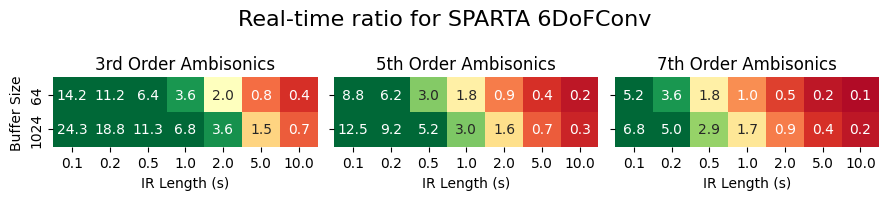

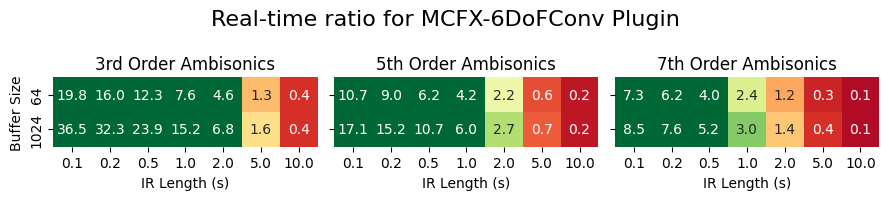

In [10]:
def create_rtratio_minimal_heatmap(data, plugin, title=False, SCATTER=True, binarycmap=True, absolute_max=1.1):
    channel_numbers = sorted(data['channels'].unique())
    buffer_sizes = sorted(data['spl'].unique())
    ir_lengths = sorted(data['irlen_s'].unique())
    ambisonics_orders = np.sqrt(channel_numbers)-1

    fig, axes = plt.subplots(1, len(channel_numbers), figsize=(9, 2), sharey=True)

    def get_plottable(data, plugin, channel_numbers, buffer_sizes, ir_lengths):
        scatter_x = [[] for _ in range(len(channel_numbers))]
        scatter_y = [[] for _ in range(len(channel_numbers))]
        scatter_color = [[] for _ in range(len(channel_numbers))]

        plottable = np.zeros((len(channel_numbers), len(buffer_sizes), len(ir_lengths)))
        for idx, channels in enumerate(channel_numbers):
            for idx2, buffer_size in enumerate(buffer_sizes):
                for idx3, ir_length in enumerate(ir_lengths):
                    plottable[idx, idx2, idx3] = data[(data['channels'] == channels) & (data['spl'] == buffer_size) & (data['irlen_s'] == ir_length) & (data['plugin'] == plugin)]['X_mean'].values[0]
                    scatter_x[idx].append(idx3) #ir_length)
                    scatter_y[idx].append(idx2) #buffer_size)
                    scatter_color[idx].append(plottable[idx, idx2, idx3])
        return plottable, (scatter_x,scatter_y,scatter_color)

    # Now, instead of computing the ratio, we plot a headmap for each of the plugins, and plot directly the values
    assert plugin in ['old','new'], 'plugin must be either "old" or "new"'
    plugindata, scatterplottables = get_plottable(data, plugin, channel_numbers, buffer_sizes, ir_lengths)
    
    if title:
        if SCATTER:
            fig.suptitle('Real-time or offline for '+('SPARTA 6DoFConv' if plugin=='old' else 'MCFX-6DoFConv Plugin') + ' with scatter', fontsize=16)
        else:
            fig.suptitle('Real-time ratio for '+('SPARTA 6DoFConv' if plugin=='old' else 'MCFX-6DoFConv Plugin'), fontsize=16)
    for idx, order in enumerate(ambisonics_orders):
        # Extract data for specific ambisonics order
        data = plugindata[idx, :, :]
        
        round_to_next_half = lambda x: np.ceil(x*2)/2
        
        if SCATTER == True:
            # print('For idx',idx)
            # print(scatterplottables[0][idx])
            # print(scatterplottables[1][idx])
            colors = ['red' if p < 1 else 'green' for p in scatterplottables[2][idx]]

            # axes[idx].scatter(scatterplottables[0][idx],scatterplottables[1][idx],c=colors,s=100, marker='+')
            # first plot only those with color red
            axes[idx].scatter([scatterplottables[0][idx][i] for i in range(len(scatterplottables[2][idx])) if scatterplottables[2][idx][i] < 1], 
                              [scatterplottables[1][idx][i] for i in range(len(scatterplottables[2][idx])) if scatterplottables[2][idx][i] < 1], 
                              c='red', s=100, marker='_')
            # then plot only those with color green
            axes[idx].scatter([scatterplottables[0][idx][i] for i in range(len(scatterplottables[2][idx])) if scatterplottables[2][idx][i] >= 1],
                              [scatterplottables[1][idx][i] for i in range(len(scatterplottables[2][idx])) if scatterplottables[2][idx][i] >= 1],
                              c='green', s=100, marker='+')
            
            # Set labels
            axes[idx].set_xlabel('IR Length (s)')
            # axes[idx].set_xticklabels(ir_lengths, rotation=0)

            borders = 0.5
            axes[idx].set_ylim(-borders,len(buffer_sizes)-1+borders)
            axes[idx].set_xlim(-borders,len(ir_lengths)-1+borders)

            if idx == 0:
                axes[idx].set_ylabel('Buffer Size')
            
            axes[idx].set_yticks(list(range(len(buffer_sizes))))
            axes[idx].set_yticklabels(buffer_sizes)

            axes[idx].set_xticks(range(len(ir_lengths)))
            axes[idx].set_xticklabels(ir_lengths)

            # Legend
            if idx == len(ambisonics_orders)-1:
                axes[idx].legend(['Non real-time','Real-time'], loc='center left', bbox_to_anchor=(1, 0.5))
            # if idx == len(ambisonics_orders)//2:
            #     axes[idx].legend(['Non real-time','Real-time'], loc='center left', bbox_to_anchor=(0.1, -1))

            
        else:
        
            # Create heatmap
            # sns.heatmap(data, 
            #             ax=axes[idx], 
            #             cmap='RdYlGn',  # Red-Yellow-Green reversed (red = worse, green = better)
            #             cbar=idx == len(ambisonics_orders)-1,  # Only add colorbar to last subplot
            #             annot=True, 
            #             fmt='.1f',
            #             vmin=0, 
            #             vmax=round_to_next_half(max(performance_ratio.max(), 1.5)),
            #             center=1,
            #             cbar_kws={'label': 'Performance Ratio'} if idx == len(ambisonics_orders)-1 else {})
            
            # Create a mask for bold borders
            # mask = np.logical_not(newPlugin_data[idx, :, :] > 1)
            # mask = np.logical_not(oldPlugin_data[idx, :, :] > 1)

            # Create heatmap
            dark_red = 'darkred'    # Dark red
            dark_green = 'green'  # Dark green
            colors = [dark_red, dark_green]
            from matplotlib.colors import ListedColormap
            binary_cmap = ListedColormap(colors)

            # print('data.max()',data.max())
            # print('absolute_max',absolute_max)

            ccbar = False if binarycmap else (idx == len(ambisonics_orders)-1)
            sns.heatmap(data, 
                        ax=axes[idx], 
                        # cmap='RdYlGn',  # Red-Yellow-Green reversed (red = worse, green = better)
                        cmap=binary_cmap if binarycmap else 'RdYlGn',  # Red-Yellow-Green reversed (red = worse, green = better)
                        cbar=False, #ccbar, #idx == len(ambisonics_orders)-1,  # Only add colorbar to last subplot
                        annot=True, 
                        fmt='.1f',
                        # vmin=0.9, 
                        # vmax=round_to_next_half(max(oldPlugin_data.max(), oldPlugin_data.max())),
                        # center=5,
                        vmin=0.9 if binarycmap else 0, 
                        vmax=1.1 if binarycmap else absolute_max,
                        # center=6,
                        cbar_kws={'label': 'Real-time Ratio'} if idx == len(ambisonics_orders)-1 else {},
                        annot_kws={'size': 10, 'rotation': 0},
                        # linewidths=.5,  # Make the gridlines thicker
                        # linecolor='white',  # Color of the gridlines
                        )
            if idx == 0:
                axes[idx].set_ylabel('Buffer Size')
            
            axes[idx].set_yticklabels(buffer_sizes)
            axes[idx].set_xticklabels(ir_lengths)
            axes[idx].set_xlabel('IR Length (s)')


        # break

        axes[idx].set_title(f'{numeral_to_ordinal(int(order))} Order Ambisonics')
    plt.tight_layout()


def get_figshape(data):
    # newPlugin_data, oldPlugin_data, ambisonics_orders, buffer_sizes, ir_lengths, 
    channel_numbers = data['channels'].unique()
    return len(channel_numbers)
    # ambisonics_orders = np.sqrt(channel_numbers)-1
    # buffer_sizes = data['spl'].unique()
    # ir_lengths = data['irlen_s'].unique()
    # return channel_numbers, ambisonics_orders, buffer_sizes, ir_lengths


# for idx,plugin in enumerate(['old','new']):
#     create_rtratio_minimal_heatmap(data,plugin, title=True)

#     outfile = os.path.join('outplots','rtratio_scatter_%s'%plugin)
#     plt.savefig(outfile+'.png', bbox_inches='tight')
#     plt.savefig(outfile+'.svg', bbox_inches='tight')
#     plt.savefig(outfile+'.pdf', bbox_inches='tight')
#     plt.show()


# # fig, axes = plt.subplots(1, get_figshape(data), figsize=(9, 4), sharey=True)
# for idx,plugin in enumerate(['old','new']):
#     create_rtratio_minimal_heatmap(data,plugin, title=True, SCATTER=False)
#     outfile = os.path.join('outplots','rtratio_heatmap_binary_%s'%plugin)
#     # plt.savefig(outfile+'.png', bbox_inches='tight')
#     # plt.savefig(outfile+'.svg', bbox_inches='tight')
#     plt.savefig(outfile+'.pdf', bbox_inches='tight')
#     plt.show()

# Absolute max should contain the maximum X_mean value for all the data
absolute_max = data['X_mean'].max()
for idx,plugin in enumerate(['old','new']):
    create_rtratio_minimal_heatmap(data,plugin, title=True, SCATTER=False, binarycmap=False,absolute_max=absolute_max//9)
    outfile = os.path.join('outplots','rtratio_heatmap_gradient_%s'%plugin)
    plt.savefig(outfile+'.png', bbox_inches='tight')
    # plt.savefig(outfile+'.svg', bbox_inches='tight')
    plt.savefig(outfile+'.pdf', bbox_inches='tight')
    plt.show()

In [11]:
readmepath = os.path.join('../','README.md')
assert os.path.exists(readmepath), 'README.md not found'

with open(readmepath,'w') as rf:
    pngplots = sorted(glob('./outplots/*.png'))
    print(pngplots)
    for pngplot in pngplots:
        pngplot.replace(r'\','/')
        rf.write('### %s\n'%pngplot)
        rf.write('![](%s)\n\n'%pngplot)

['./outplots\\rtratio_heatmap_gradient_new.png', './outplots\\rtratio_heatmap_gradient_old.png', './outplots\\speedup_heatmap.png']
